In [1]:
import cv2
import numpy as np
import random
import os, sys, glob, pickle
from xml.dom import minidom
import matplotlib.path as mplPath
import numpy as np
import openslide
import time
import pdb
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
resnet50 = models.resnet50(pretrained=True).to(device)

In [4]:
MODEL_PATH = '_ckpt_epoch_9.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model


model = models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location=device)

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)

if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.cuda()

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self, model):
        super(SiameseNetwork, self).__init__()
        self.model = model
    
    def forward_once(self, x):
        out = self.model(x)
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

In [6]:
class SiamDataset(Dataset):
    def __init__(self, img_file_list, mode='load', affine_param=5, jitter_param=0.4):
        self.img_file_list = img_file_list
        
        self.mode = mode
        if mode=='create':
            self.single_transform = torchvision.transforms.Compose([
                torchvision.transforms.RandomCrop(224),
                torchvision.transforms.ToTensor()
            ])
            self.augment = torchvision.transforms.Compose([
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomAffine(affine_param),
                torchvision.transforms.ColorJitter(
                    brightness=jitter_param,
                    contrast=jitter_param,
                    saturation=jitter_param)
            ])

            self.wsi_list = []
            self.wsi_weight = []
            for img_file in img_file_list:
                wsi = Image.open(img_file).convert('RGB')
                self.wsi_list.append(wsi)
                h,w = wsi.size
                self.wsi_weight.append(h*w)
        
    def sample(self):
        wsi = random.choices(self.wsi_list, weights=self.wsi_weight)[0]

        img = self.single_transform(wsi)
        
        return img
               
        
    def __getitem__(self, index):
        if self.mode=='create':
            img1 = self.sample()

            augment = np.random.binomial(1,0.5)

            img2 = self.augment(img1) if augment else self.sample()
        else:
            pkl = open(self.img_file_list[index], "rb")
            img1, img2, augment = pickle.load(pkl)
            pkl.close()
        
        return [img1, img2, augment]
        
        
        
    def __len__(self):
        if self.mode=='create':
            acc = 0
            for wsi in self.wsi_list:
                h,w = wsi.size
                acc += 1.*h*w/(224*224)
            return int(acc)
        
        return len(self.img_file_list)

In [7]:
def create_dataset():
    img_file_list = glob.glob("/home/karman/DDP/TCGA_expt/TCGA_dataset/*/*.png")
    dataset = SiamDataset(img_file_list, mode='create')

    out_file_path = "/home/karman/DDP/BrC_GraphMIL/data/tcga_"
    if not os.path.exists(out_file_path):
        os.makedirs(out_file_path)

    torch.manual_seed(77077)
    random.seed(71017)

    idx=0
    for data in dataset:
        pickle_out = open(out_file_path+str(idx),"wb")
        pickle.dump(data, pickle_out)
        pickle_out.close()
        idx += 1
        if idx>=len(dataset):
            break

In [7]:
class ContrastiveLoss(nn.Module):
    # label == 1 means same sample, label == 0 means different samples
    def __init__(self, margin=0., do_average=True):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-6
        self.relu = nn.ReLU()
        self.do_average = do_average
    
    def forward(self, out1, out2, labels):
        dist = (out1 - out2).pow(2).sum(1)
        loss = 0.5*(labels*dist + 
                   (1 + -1.*labels)*self.relu(self.margin - (dist+self.eps).sqrt()).pow(2))
        return loss.mean() if self.do_average else loss.sum()

In [8]:
def train(args, model, device, loss_fn, train_loader, optimizer, num_epochs):
    
    
    for epoch in range(num_epochs): 
        epoch_loss = 0
        for batch_idx, data in enumerate(train_loader):
            x1 = data[0].to(device)
            x2 = data[1].to(device)
            label = data[2].to(device)

            optimizer.zero_grad()

            model.train()

            out1, out2 = model(x1, x2)

            loss = loss_fn(out1, out2, label) # calculates the loss
            curr_loss = loss.item()
            loss.backward()
            optimizer.step()
            epoch_loss += curr_loss
            
            del x1
            del x2
            del label
            
            if batch_idx % args['log_interval'] == 0 :
                print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 100. * (batch_idx+1) / len(train_loader), curr_loss))

In [8]:
args = {}
args['batch_size'] = 150
args['epochs'] = 3
args['seed']=990077
args['lr']=0.01
args['train_ratio']=0.8
args['log_interval']=2

torch.manual_seed(args['seed'])

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [9]:
siamNetwork = SiameseNetwork(model)

data_file_list = sorted(glob.glob("/home/karman/DDP/BrC_GraphMIL/data/*"))
dataset = SiamDataset(data_file_list)

train_loader = DataLoader(dataset=dataset, batch_size=args['batch_size'], shuffle = True, **kwargs)

loss_fn = ContrastiveLoss(do_average=False)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

In [12]:
train(args, siamNetwork, device, loss_fn, train_loader, optimizer, args['epochs'])

Train Epoch: 0 [(1%)]	Loss: 4010.889160
Train Epoch: 0 [(2%)]	Loss: 7833.989258
Train Epoch: 0 [(3%)]	Loss: 3005.781738
Train Epoch: 0 [(4%)]	Loss: 1219.138428
Train Epoch: 0 [(5%)]	Loss: 746.669922
Train Epoch: 0 [(6%)]	Loss: 348.080536
Train Epoch: 0 [(7%)]	Loss: 247.353622
Train Epoch: 0 [(8%)]	Loss: 223.987793
Train Epoch: 0 [(9%)]	Loss: 122.580803
Train Epoch: 0 [(10%)]	Loss: 135.615372
Train Epoch: 0 [(11%)]	Loss: 66.444260
Train Epoch: 0 [(12%)]	Loss: 64.588120
Train Epoch: 0 [(13%)]	Loss: 49.533897
Train Epoch: 0 [(14%)]	Loss: 30.605421
Train Epoch: 0 [(15%)]	Loss: 28.715691
Train Epoch: 0 [(16%)]	Loss: 75.868134
Train Epoch: 0 [(17%)]	Loss: 25.866150
Train Epoch: 0 [(18%)]	Loss: 75.945900
Train Epoch: 0 [(19%)]	Loss: 11.110758
Train Epoch: 0 [(20%)]	Loss: 8.073780
Train Epoch: 0 [(21%)]	Loss: 29.769436
Train Epoch: 0 [(22%)]	Loss: 7.558384
Train Epoch: 0 [(23%)]	Loss: 16.887102
Train Epoch: 0 [(24%)]	Loss: 20.699158
Train Epoch: 0 [(25%)]	Loss: 26.429977
Train Epoch: 0 [(26%)]

Train Epoch: 2 [(21%)]	Loss: 0.016776
Train Epoch: 2 [(22%)]	Loss: 0.069875
Train Epoch: 2 [(23%)]	Loss: 0.033951
Train Epoch: 2 [(24%)]	Loss: 0.684711
Train Epoch: 2 [(25%)]	Loss: 0.244144
Train Epoch: 2 [(26%)]	Loss: 0.081406
Train Epoch: 2 [(27%)]	Loss: 0.281215
Train Epoch: 2 [(28%)]	Loss: 0.322104
Train Epoch: 2 [(29%)]	Loss: 0.127192
Train Epoch: 2 [(30%)]	Loss: 0.039770
Train Epoch: 2 [(31%)]	Loss: 0.055641
Train Epoch: 2 [(32%)]	Loss: 0.180996
Train Epoch: 2 [(33%)]	Loss: 0.126547
Train Epoch: 2 [(34%)]	Loss: 0.206373
Train Epoch: 2 [(35%)]	Loss: 0.081660
Train Epoch: 2 [(36%)]	Loss: 0.194551
Train Epoch: 2 [(37%)]	Loss: 0.164539
Train Epoch: 2 [(38%)]	Loss: 0.283443
Train Epoch: 2 [(39%)]	Loss: 0.307433
Train Epoch: 2 [(40%)]	Loss: 0.036769
Train Epoch: 2 [(41%)]	Loss: 0.045006
Train Epoch: 2 [(42%)]	Loss: 0.021516
Train Epoch: 2 [(43%)]	Loss: 0.079114
Train Epoch: 2 [(44%)]	Loss: 0.281538
Train Epoch: 2 [(45%)]	Loss: 0.092706
Train Epoch: 2 [(46%)]	Loss: 0.023920
Train Epoch:

In [13]:
torch.save({
    'epoch': args['epochs'],
    'model_state_dict': siamNetwork.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, 'checkpoints/siamese_3epoch_1wsi_lossSum.pth.tar')

In [61]:
checkpoint = torch.load('checkpoints/siamese_3epoch_1wsi_lossSum.pth.tar')
args['epochs'] = checkpoint['epoch']
siamNetwork.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [91]:
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from time import time
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
%matplotlib inline

# Next line to silence pyflakes. This import is needed.
Axes3D



mpl_toolkits.mplot3d.axes3d.Axes3D

In [45]:
# get 2000 images embedded for tsne
img_file_list = glob.glob("/home/karman/DDP/TCGA_expt/TCGA_dataset/*/*.png")
dataset = SiamDataset(img_file_list, mode='create')

In [63]:
torch.manual_seed(90515)
random.seed(88054)

count = 0
data_arr = []

siamNetwork.eval()

with torch.no_grad():
    for idx in range(2000):
        img = dataset.sample()
        data_arr.append(siamNetwork.forward_once(img.unsqueeze(dim=0).to(device)))

        del img


In [51]:
print(len(data_arr[0]))
print(type(data_arr[0]))
data_arr[0].shape

1
<class 'torch.Tensor'>


torch.Size([1, 512])

In [60]:
# loss mean
x = 0.
for i in data_arr:
    x += torch.sum(i)
print(x)

tensor(82.4895, device='cuda:0')


In [64]:
# loss sum
x = 0.
for i in data_arr:
    x += torch.sum(i)
print(x)

tensor(153.3267, device='cuda:0')


In [81]:
x = data_arr
x = np.asarray([i.cpu().numpy() for i in x])
X = x.squeeze().shape
type(X)

tuple

In [95]:
x = data_arr
x = np.asarray([i.cpu().numpy() for i in x])
X = x.squeeze()

# n_components = X.shape[-1]
n_components = 2

method = manifold.TSNE(n_components=n_components, init='pca', random_state=79)


No handles with labels found to put in legend.


1: 4.5 sec


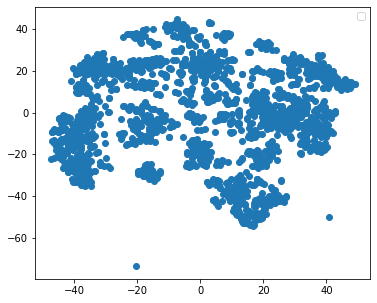

In [94]:
# # Create figure
# fig = plt.figure()

# # Add 3d scatter plot
# ax = fig.add_subplot(251, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

t0 = time()
Y = method.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % (label, t1 - t0))
# # ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
# ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
# ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# ax.axis('tight')

# plt.show()




plt.figure(figsize=(6, 5))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
# for i, c, label in zip(target_ids, colors, digits.target_names):
plt.scatter(Y[:, 0], Y[:, 1])#, c=c, label=label)
plt.legend()
plt.show()